In order to check the effectiveness of our model, we want to now how correlated our data is to gas. To do that we want a dataframe that holds all the data in a pairwise fasion (this means that the data points line up to one another), then we can check how correlated the data is.

In [43]:
import pandas as pd
import numpy as np
import scipy as sp
import datetime

from pytrends.request import TrendReq

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats.stats import pearsonr

import matplotlib.pyplot as plt
#from graphviz import Digraph
from collections import deque
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels.api as sm

In [2]:
pytrends = TrendReq(hl='en-US', tz=360)
kw = "Gas prices"
kw_list = [kw]
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')

# Get the gasoline interest dataframe.
interest_df = pytrends.interest_over_time()
interest_df.head()

,Gas prices,isPartial
date,,
2004-01-01,5,False
2004-02-01,6,False
2004-03-01,11,False
2004-04-01,11,False
2004-05-01,33,False


In [3]:
df_dji = pd.read_csv("data/DJI.csv") ## Reading DJI
df_sp500 = pd.read_csv('data/S&P500.csv')
file = pd.ExcelFile("data/GAS.xls")   ## Load the gas prices database
df_nas = pd.read_csv('data/NASDAQ.csv')

#Column selection
df_gas= file.parse('Data 1', header=2, ncolumns=2) # Parse the file, saving as our database
df_gas = df_gas[['Date', 'Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)']]
df_gas = df_gas.rename(index=str, columns={"Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)": "gas_price"})
df_nas = df_nas[['Date', 'Close']]
df_interest = interest_df[['Gas prices']]
#Stocks
df_dji = df_dji[['Date', 'Close']]
df_sp500 = df_sp500[['Date', 'Close']]

#Dropping NaN values
df_gas.dropna(axis=0, inplace=True)
df_sp500.dropna(axis=0, inplace=True)
df_dji.dropna(axis=0, inplace=True)
df_nas.dropna(axis=0, inplace=True)

#Converting dates from string to datetime
df_dji['Date'] = pd.to_datetime(df_dji.Date)
df_sp500['Date'] = pd.to_datetime(df_sp500.Date)
df_gas['Date'] = pd.to_datetime(df_gas.Date)
df_nas['Date'] = pd.to_datetime(df_nas.Date)

#Set indexes
df_dji.set_index('Date', inplace = True)
df_gas.set_index('Date', inplace = True)
df_sp500.set_index('Date', inplace = True)
df_nas.set_index('Date', inplace = True)

#Rename Columns for our Master/Cross-Correlational Dataframe
df_dji = df_dji.rename(columns ={'Close': "DJI"})
df_sp500 = df_sp500.rename(columns ={'Close': "SP500"})
df_nas = df_nas.rename(columns ={'Close': "NASDAQ"})

In [4]:
#Upsampling Google Trends Data
upsample = df_interest.resample('D')
interpolated = upsample.interpolate(method='linear')
df_interest = interpolated

In [5]:
df_interest.head()

,Gas prices
date,
2004-01-01,5.000000
2004-01-02,5.032258
2004-01-03,5.064516
2004-01-04,5.096774
2004-01-05,5.129032


In [6]:
df_gas.head()

,gas_price
Date,
1993-04-05,1.068
1993-04-12,1.079
1993-04-19,1.079
1993-04-26,1.086
1993-05-03,1.086


In [7]:
df_dji.head()

,DJI
Date,
1985-01-29,1292.619995
1985-01-30,1287.880005
1985-01-31,1286.770020
1985-02-01,1277.719971
1985-02-04,1290.079956


In [8]:
df_sp500.head()

,SP500
Date,
1950-01-03,16.66
1950-01-04,16.85
1950-01-05,16.93
1950-01-06,16.98
1950-01-09,17.08


In [9]:
df_nas.head()

,NASDAQ
Date,
1971-02-05,100.000000
1971-02-08,100.839996
1971-02-09,100.760002
1971-02-10,100.690002
1971-02-11,101.449997


We can now combine these dataframes into one to get how correlated they are. So we want to join the dataframes on their dates so that they line up to do a pairwise comparision. Then we want to drop any null values so that they are do not affect the analysis.

In [10]:
df_corr = pd.concat([df_gas, df_dji, df_sp500, df_nas], axis=1, join_axes=[df_gas.index])
df_corr = df_corr.rename(columns={"gas_price": "Gas", "DJI": "Dow Jones", "SP500": "S&P 500"})
df_corr.dropna(axis=0, inplace = True)   #Drop null values
df_corr.head(10)

,Gas,Dow Jones,S&P 500,NASDAQ
Date,,,,
1993-04-05,1.068,3379.189941,442.290009,670.710022
1993-04-12,1.079,3428.090088,448.369995,673.119995
1993-04-19,1.079,3466.989990,447.459991,663.030029
1993-04-26,1.086,3398.370117,433.540009,645.869995
1993-05-03,1.086,3446.459961,442.459991,666.710022
1993-05-10,1.097,3443.280029,442.799988,682.820007
1993-05-17,1.106,3449.929932,440.369995,677.960022
1993-05-24,1.106,3507.780029,448.000000,694.690002
1993-06-07,1.104,3532.129883,447.690002,694.609985


In [11]:
##This is necessary because the indexes of Google Trends are not similar to that of the stock data, as the data begins in 2004.
df_corr_trends = pd.concat([df_gas, df_interest], axis=1, join_axes=[df_gas.index])
df_corr_trends = df_corr_trends.rename(columns={"gas_price": "Gas","Gas prices": "Google Trends"})
df_corr_trends.dropna(axis=0, inplace = True)   #Drop null values
len(df_corr_trends)

800

In [12]:
## Create 1D numpy arrays from dataframe columns
dji_array = df_corr['Dow Jones'].values
SP500_array = df_corr['S&P 500'].values
NASDAQ_array = df_corr['NASDAQ'].values
gas_array = df_corr['Gas'].values
gas_trends_array = df_corr_trends['Gas'].values
trends_array = df_corr_trends['Google Trends'].values
print(dji_array.shape, SP500_array.shape, NASDAQ_array.shape, gas_array.shape, gas_trends_array.shape, trends_array.shape)

(1235,) (1235,) (1235,) (1235,) (800,) (800,)


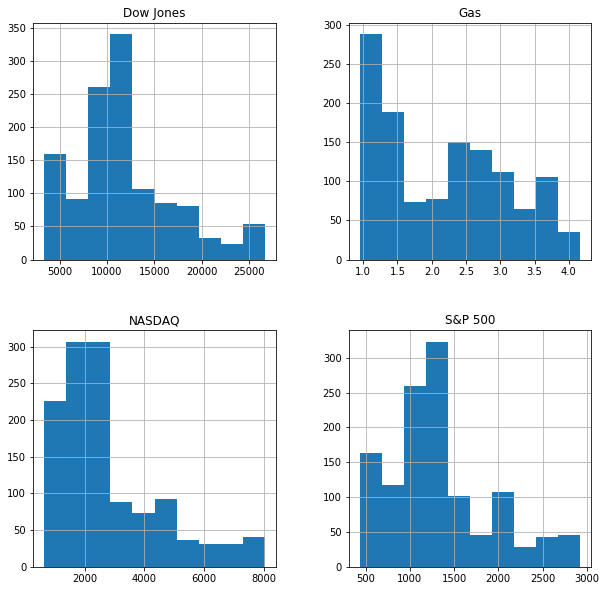

In [13]:
df_corr.hist(figsize = (10,10));

Since these original series are not normally distributed, we will use the spearman non-parametric correlation test to see if they are correlated. 

In [14]:
df_corr.corr(method='spearman')

,Gas,Dow Jones,S&P 500,NASDAQ
Gas,1.000000,0.749707,0.642804,0.662385
Dow Jones,0.749707,1.000000,0.974835,0.960259
S&P 500,0.642804,0.974835,1.000000,0.978440
NASDAQ,0.662385,0.960259,0.978440,1.000000


In [15]:
df_corr_trends.corr(method='spearman')

,Gas,Google Trends
Gas,1.000000,0.393141
Google Trends,0.393141,1.000000


All of our indices seem pretty interrcorrelated to each other, however, this doesn't give us the full picture, since each series can have effects on other series both into the past and into the future. To zoom in, we perform spearman correlation tests from -20 lag to +20 lag to see how correlation changes as we increase/decrease lags.

In [16]:
rhos_dji = []
pvals_dji = []
rhos_sp500 = []
pvals_sp500 = []
rhos_nasdaq = []
pvals_nasdaq = []
rhos_trends = []
pvals_trends = []

for lag in range(-20, 20):
    rho, pval = sp.stats.spearmanr(dji_array, pd.Series(gas_array).shift(lag).fillna(0))
    rhos_dji.append(rho)
    pvals_dji.append(pval)
    rho, pval = sp.stats.spearmanr(SP500_array, pd.Series(gas_array).shift(lag).fillna(0))
    rhos_sp500.append(rho)
    pvals_sp500.append(pval)
    rho, pval = sp.stats.spearmanr(NASDAQ_array, pd.Series(gas_array).shift(lag).fillna(0))
    rhos_nasdaq.append(rho)
    pvals_nasdaq.append(pval)
    rho, pval = sp.stats.spearmanr(trends_array, pd.Series(gas_trends_array).shift(lag).fillna(0))
    rhos_trends.append(rho)
    pvals_trends.append(pval)

## Non-Parametric Correlation

We plotted the cross-correlation between all stock data and google trends data to gas prices. The cross-correlation is roughly normally distributed.

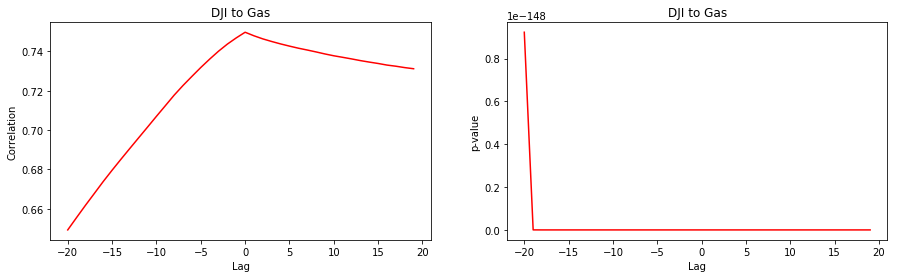

In [17]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(-20, 20), rhos_dji, color = 'r')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title('DJI to Gas')

plt.subplot(1, 2, 2)
plt.plot(np.arange(-20, 20), pvals_dji, color = 'r')
plt.xlabel("Lag")
plt.ylabel("p-value")
plt.title('DJI to Gas')

plt.show()

In [18]:
print('lowest p-val: ', min(pvals_dji))
print('lag value: ', pvals_dji.index(min(pvals_dji)) - 20)
print('rho statistic: {}'. format(rhos_dji[pvals_dji.index(min(pvals_dji))]))

lowest p-val:  2.5891188260250825e-223
lag value:  0
rho statistic: 0.7497067871211748


Looks like the p-values for all the lags are signifcant, the most correlated & significant being lag 0, with a coefficient of .75. This means that the dow jones index is fairly correlated with gas prices. Even if they're not normally distributed, we can still plot them to see if DJI and gas prices have a monotonous relationship.

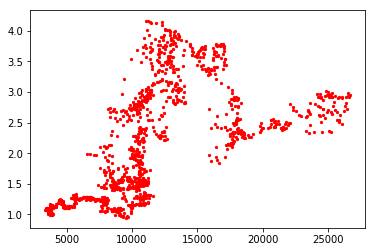

In [19]:
plt.scatter(dji_array, gas_array, s = 5, color = 'r');

Looks like they do have a rough monotonous relationship. Increases in DJI are coupled with increases in gas prices, although the relationship is not always linear. We can't say more than that because of the non-parametric nature of time series. We continue with the same approach for the rest of our indices.

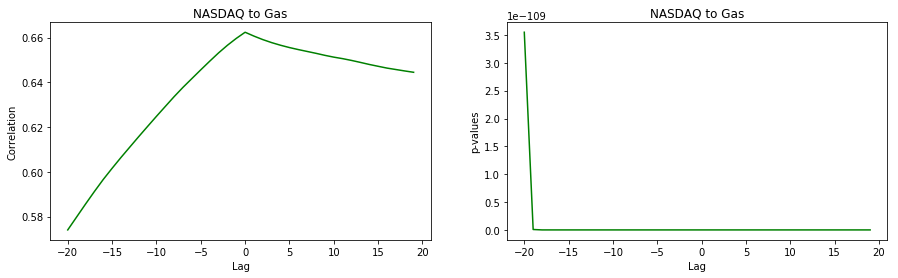

In [20]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(-20, 20), rhos_nasdaq, color = 'g')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title('NASDAQ to Gas')

plt.subplot(1, 2, 2)
plt.plot(np.arange(-20, 20), pvals_nasdaq, color = 'g')
plt.xlabel("Lag")
plt.ylabel("p-values")
plt.title('NASDAQ to Gas')

plt.show()

In [21]:
print('lowest p-val: ', min(pvals_nasdaq))
print('lag value: ', pvals_nasdaq.index(min(pvals_nasdaq)) - 20)
print('rho statistic: {}'. format(rhos_nasdaq[pvals_nasdaq.index(min(pvals_nasdaq))]))

lowest p-val:  7.724219731446547e-157
lag value:  0
rho statistic: 0.6623849906096626


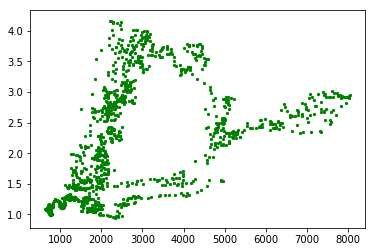

In [22]:
plt.scatter(NASDAQ_array, gas_array, s = 5, color = 'g');

We see that the lowest p-value, which is below 0.05, is at lag 0 with a r value of about 0.750

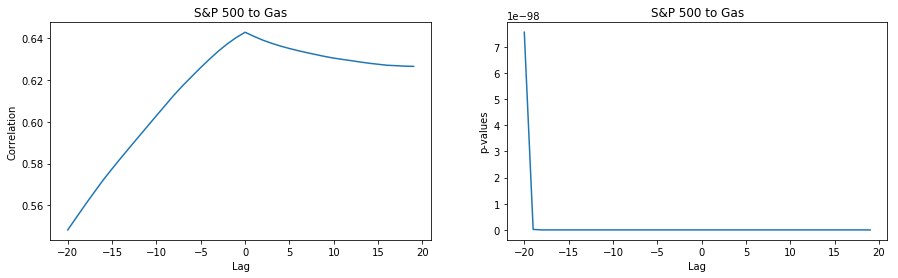

In [23]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(-20, 20), rhos_sp500)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title('S&P 500 to Gas')

plt.subplot(1, 2, 2)
plt.plot(np.arange(-20, 20), pvals_sp500)
plt.xlabel("Lag")
plt.ylabel("p-values")
plt.title('S&P 500 to Gas')

plt.show()

In [24]:
print('lowest p-val: ', min(pvals_sp500))
print('lag value: ', pvals_sp500.index(min(pvals_sp500)) - 20)
print('rho statistic: {}'. format(rhos_sp500[pvals_sp500.index(min(pvals_sp500))]))

lowest p-val:  6.66048581929013e-145
lag value:  0
rho statistic: 0.6428036844556213


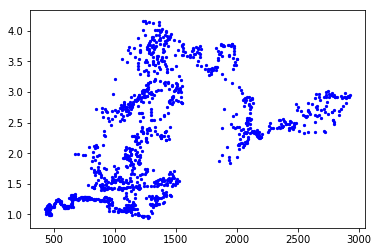

In [25]:
plt.scatter(SP500_array, gas_array, s = 5, color = 'b');

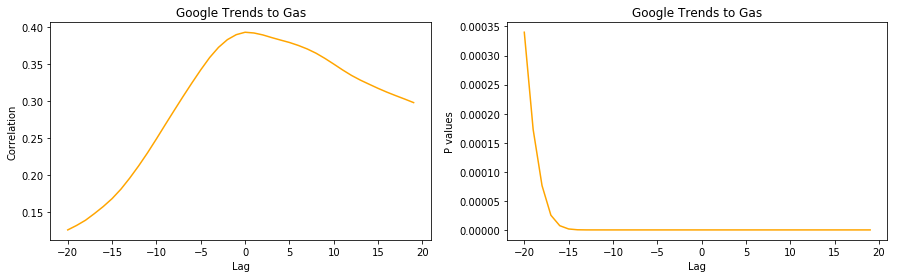

In [26]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(-20, 20), rhos_trends, color = 'orange')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title('Google Trends to Gas')

plt.subplot(1, 2, 2)
plt.plot(np.arange(-20, 20), pvals_trends, color = 'orange')
plt.xlabel("Lag")
plt.ylabel("P values")
plt.title('Google Trends to Gas')
plt.show()

In [27]:
print('lowest p-val: ', min(pvals_trends))
print('lag value: ', pvals_trends.index(min(pvals_trends)) - 20)
print('rho statistic: {}'. format(rhos_trends[pvals_trends.index(min(pvals_trends))]))

lowest p-val:  5.747356964397835e-31
lag value:  0
rho statistic: 0.39314057466942764


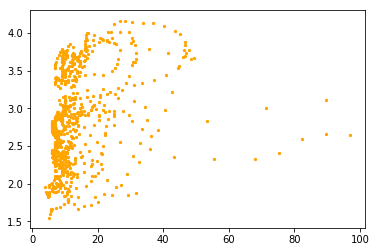

In [28]:
plt.scatter(trends_array, gas_trends_array, s = 5, color = 'orange');

We see a similar trend with the rest of the indices, with their peaks all at lag 0 and their peak correlation values from .6 to .8, except for google trends data which is at .4. It is also evident from the plot that google trends is less correlated than the stocks. What's also interesting is that we see correlation values drop off as we move away from lag 0, but it doesn't drop off very quickly. This could imply that if gas prices are influenced by stock prices and general performance of the economy, the effect is not just contemporaneous (past values influence both present and future values).

Now we know for sure that lag zero is the most signficant, we summarize our findings in a scatter matrix:

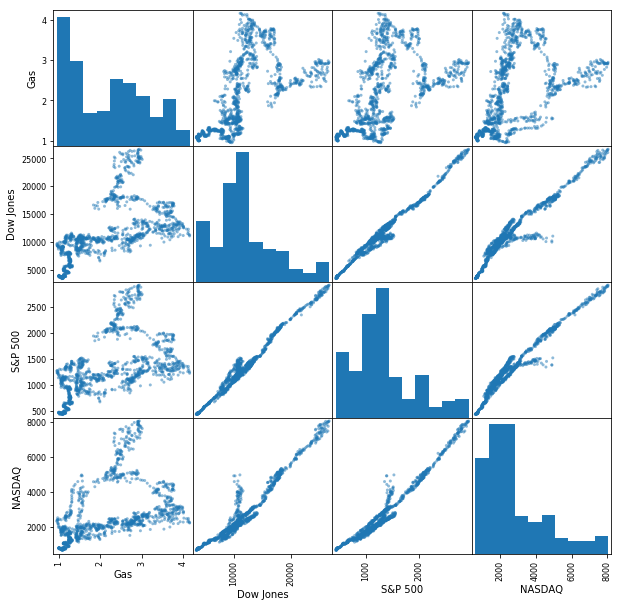

In [29]:
pd.plotting.scatter_matrix(df_corr, figsize = (10,10));

This gives us some more information in that stocks are very heavily correlated with each other.

# Differencing the Data

Now we will difference the data to get our time-series to be stationary. This allows us to make more conclusive statements about the correlation of our data. After differencing, we are essentially dealing with the derivatives of our data, which is how they change from one week to the next. 

In [30]:
## Difference the data to get a stationary time series
dji_array = pd.Series(np.diff(dji_array))
SP500_array = pd.Series(np.diff(SP500_array))
NASDAQ_array = pd.Series(np.diff(NASDAQ_array))
gas_array = pd.Series(np.diff(gas_array))
gas_trends_array = pd.Series(np.diff(gas_trends_array))
trends_array = pd.Series(np.diff(trends_array))

In [31]:
df_corr.head()

,Gas,Dow Jones,S&P 500,NASDAQ
Date,,,,
1993-04-05,1.068,3379.189941,442.290009,670.710022
1993-04-12,1.079,3428.090088,448.369995,673.119995
1993-04-19,1.079,3466.989990,447.459991,663.030029
1993-04-26,1.086,3398.370117,433.540009,645.869995
1993-05-03,1.086,3446.459961,442.459991,666.710022


In [32]:
df_corr['Gas'] = df_corr['Gas'].diff()
df_corr['Dow Jones'] = df_corr['Dow Jones'].diff()
df_corr['S&P 500'] = df_corr['S&P 500'].diff()
df_corr['NASDAQ'] = df_corr['NASDAQ'].diff()
df_corr.dropna(axis=0, inplace = True)

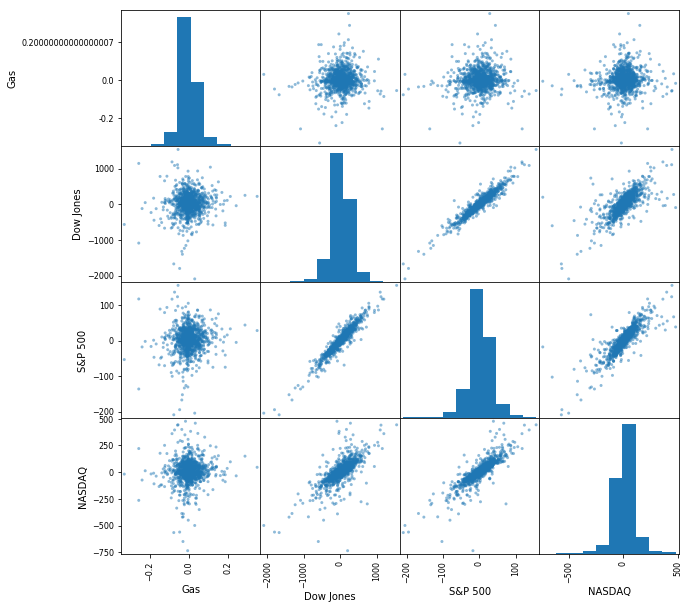

In [40]:
pd.plotting.scatter_matrix(df_corr, figsize = (10,10));

From this scatter matrix, we get a sense that our differenced data is normal and that there are signifcant correlations we can use to do a linear regression, so we preform a normal test on all of the data.

In [42]:
def isnormal(arr, alpha = .05):
    stat, pval = sp.stats.normaltest(arr)
    if pval < alpha:
        return False
    if pval > alpha:
        return True
    
df_corr.apply(isnormal)

Gas          False
Dow Jones    False
S&P 500      False
NASDAQ       False
dtype: bool

After all the normal tests, all the p-values were below 0.05 which tells us the data is actually not normal. Looking at the histogram again, this might be a kurtosis issue, since stock have drastic changes, thus giving outliers. This means we still cannot perform a pearson test. However, we can still use a least squares regression to model changes in gas prices from chagnes in stocks. We drop the google trends data because of sample size issues

In [47]:
X = df_corr[['Dow Jones', 'S&P 500', 'NASDAQ']]
y = df_corr['Gas']

olsmod = sm.OLS(y, X)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                    Gas   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.414
Date:                Wed, 12 Jun 2019   Prob (F-statistic):             0.0169
Time:                        14:40:53   Log-Likelihood:                 1921.1
No. Observations:                1234   AIC:                            -3836.
Df Residuals:                    1231   BIC:                            -3821.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Dow Jones  -2.329e-05   1.92e-05     -1.216      0.2

From the results, we can see that none of the stocks changes were very predictive of gas changes, even though they were fairly correlated. This gives an important insight: just because they are correlated does not mean they will be able to accurately predict gas prices.